In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_file
from tqdm import tqdm

repo_path = "/Users/milton/Documents/Academics/School/USF-MSCS\
/Machine Learning/project/rsna-miccai-brain-tumor-radiogenomic-classification"

train_path = repo_path + "/train"
test_path = repo_path + "/test"
pngs_train_path = repo_path + "/pngs/train"
pngs_test_path = repo_path + "/pngs/test"

(512, 512) 2196 54.608421325683594


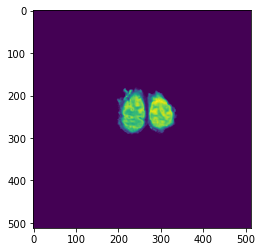

In [2]:
# Accessing single dicom image and displaying it
img_path = repo_path + "/train/00005/FLAIR/Image-72.dcm"
ds = dcmread(img_path)
arr = ds.pixel_array

print(arr.shape, np.max(arr), np.mean(arr))
plt.imshow(arr)
plt.show()

### Get maximum number of scans per type of scan

In [3]:
from os import listdir, makedirs
from os.path import isfile, isdir, join

def getScanNums(data_path):
    patients = (f for f in listdir(data_path) if isdir(join(data_path, f))) # Get all patient directories
    scan_nums = {}

    for patient in patients: # Iterate through the patients
        patient_scans = join(data_path, patient)
        scan_types = (f for f in listdir(patient_scans) if isdir(join(patient_scans, f)))
        for scan_type in scan_types: # Iterate through current patient's scan types
            scan = listdir(join(patient_scans, scan_type))
            if scan_type in scan_nums: # Get max num of scan per type from entire dataset
                scan_nums[scan_type] = (len(scan) if len(scan) > scan_nums[scan_type] else scan_nums[scan_type])
            else:
                scan_nums[scan_type] = len(scan)
    return scan_nums

In [4]:
print("Train: ", getScanNums(train_path))
print("Test: ", getScanNums(test_path))

Train:  {'FLAIR': 514, 'T1wCE': 400, 'T1w': 400, 'T2w': 472}
Test:  {'FLAIR': 412, 'T1wCE': 352, 'T1w': 352, 'T2w': 464}


### Convert Images to Gray Scale

In [5]:
from pydicom.pixel_data_handlers.util import apply_voi_lut

def grayScale(path):
    dicom = pydicom.read_file(path)             
    data = dicom.pixel_array
   
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

The img is : (512, 512) 255 0 6.318538665771484


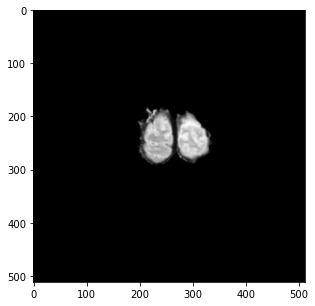

In [6]:
img = grayScale(img_path)
plt.figure(figsize = (5,5))
plt.imshow(img, 'gray')
print("The img is :", img.shape, np.max(img), np.min(img), np.mean(img))

### Crop Images

In [7]:
def crop(img, padding):
    mi=np.array(np.nonzero(img)).min(axis=1)
    ma=np.array(np.nonzero(img)).max(axis=1)
    
    mi = [(mi[0] - padding), (mi[1] - padding)]
    ma = [(ma[0] + padding), (ma[1] + padding)]
    
    return img[mi[0]:ma[0],mi[1]:ma[1]]

'(512, 512)'

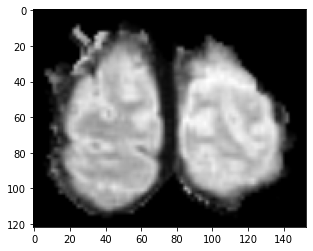

In [8]:
cropped_img = crop(img, 5)
plt.imshow(cropped_img, 'gray')
str(img.shape)

### Resize Images

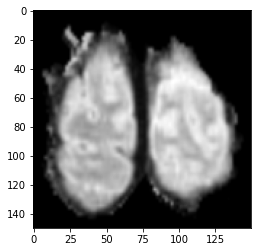

(150, 150)

In [9]:
from skimage.transform import resize as re
import cv2

def resize(img, size):
    resized_img = re(img, size, anti_aliasing=True)
    return (resized_img * 255).astype(np.uint8)

resized_img = resize(cropped_img, (150, 150))
plt.imshow(resized_img, 'gray')
plt.show()
resized_img.shape

### Create and Save Image as PNG

In [10]:
def savePNG(data, path, png_master_dir):
    image_name = path.split('/')[4:][-1].split('.')[0] # Get image name
    png_name = image_name + '.png' # Make new png name
    patient_id = path.split('/')[-3] # Get patient id
    scan_type = path.split('/')[-2] # Get type of scan
    
    png_path = png_master_dir + '/' + patient_id + '/' + scan_type # Make new png path
   
    if not isdir(png_path): # If path doesn't exist, then create it
        makedirs(png_path)
        
    png = png_path + '/' + png_name # Save png to png path
    imageio.imsave(png, data)

In [11]:
gray_scaled_img = grayScale(img_path)
cropped_img = crop(gray_scaled_img, 5)
resized_img = resize(cropped_img, (150, 150))
savePNG(resized_img, img_path, pngs_train_path)

### Get Dimensions of Scans

In [12]:
def isValid(img_path, threshold = 50):
    img = dcmread(img_path)
    px_arr = img.pixel_array
    return (np.mean(px_arr) >= threshold)

In [13]:
def getDims(data_path):
    patients = list((f for f in listdir(data_path) if isdir(join(data_path, f)))) # Get all patient directories
    max_dims = [0,512,0]
    shapes = []

    for patient in tqdm(patients, ncols=75): # Iterate through the patients
        patient_scans = join(data_path, patient)
        scan_types = (f for f in listdir(patient_scans) if isdir(join(patient_scans, f)))

        for scan_type in scan_types: # Iterate through current patient's scan types
            scan_type_list = listdir(join(patient_scans, scan_type))
            for scan in scan_type_list: # Iterate through scans for current scan type
                img_path = join(join(patient_scans, scan_type), scan) # Get image path
                if isValid(img_path): # Check if image is worth analyzing
                    img = grayScale(img_path)
                    valid_img = crop(img, 0)
                    if (img.shape[0] not in shapes) or (img.shape[1] not in shapes):
                        shapes.append(img.shape)
                    img_size = abs(valid_img.shape[0] - valid_img.shape[1])
                    max_dims[0] = (img_size if img_size > max_dims[0] else max_dims[0])
                    max_dims[1] = (valid_img.shape[0] if valid_img.shape[0] < max_dims[1] else max_dims[1])
                    max_dims[2] = (valid_img.shape[1] if valid_img.shape[1] > max_dims[2] else max_dims[2])
           
    return max_dims, shapes

In [17]:
max_dims, img_shapes = getDims(train_path)

100%|████████████████████████████████████| 582/582 [18:31<00:00,  1.91s/it]


In [18]:
print(max_dims, set(img_shapes))

[196, 28, 614] {(1024, 1014), (448, 336), (384, 312), (448, 406), (768, 768), (512, 424), (320, 260), (640, 640), (240, 240), (384, 336), (256, 208), (320, 272), (512, 384), (672, 672), (512, 448), (384, 348), (512, 512), (448, 448), (448, 512), (320, 290), (256, 232), (512, 408), (320, 250), (232, 256), (480, 480), (256, 192), (320, 256), (384, 320), (256, 256), (320, 320), (512, 432), (256, 204), (320, 280), (256, 216), (440, 440), (320, 240), (512, 416), (512, 480), (448, 364), (244, 244), (384, 288), (320, 236), (256, 224), (512, 464)}


##### The max dims for the training set are [196, 28, 614] [img_size, min_row, max_cols] w/ padding 0

##### Set of image dims: [196, 28, 614] {(1024, 1014), (448, 336), (384, 312), (448, 406), (768, 768), (512, 424), (320, 260), (640, 640), (240, 240), (384, 336), (256, 208), (320, 272), (512, 384), (672, 672), (512, 448), (384, 348), (512, 512), (448, 448), (448, 512), (320, 290), (256, 232), (512, 408), (320, 250), (232, 256), (480, 480), (256, 192), (320, 256), (384, 320), (256, 256), (320, 320), (512, 432), (256, 204), (320, 280), (256, 216), (440, 440), (320, 240), (512, 416), (512, 480), (448, 364), (244, 244), (384, 288), (320, 236), (256, 224), (512, 464)}

### Gray Scale, Crop and Resize all valid scans and save them as PNGs in Disk

In [21]:
def curateScans(data_path, pngs_path):
    patients = list((f for f in listdir(data_path) if isdir(join(data_path, f)))) # Get all patient directories

    for patient in tqdm(patients, ncols=75): # Iterate through the patients
        patient_scans = join(data_path, patient)
        scan_types = (f for f in listdir(patient_scans) if isdir(join(patient_scans, f)))

        for scan_type in scan_types: # Iterate through current patient's scan types
            scan_type_list = listdir(join(patient_scans, scan_type))
            for scan in scan_type_list: # Iterate through scans for current scan type
                img_path = join(join(patient_scans, scan_type), scan) # Get image path
                if isValid(img_path): # Check if image is worth analyzing
                    gray_scaled_img = grayScale(img_path)
                    cropped_img = crop(gray_scaled_img, 5)
                    if cropped_img.size != 0: # Image transformation may make it invalid
                        resized_img = resize(cropped_img, (150, 150))
                        savePNG(resized_img, img_path, pngs_path)

In [23]:
curateScans(train_path, pngs_train_path)

100%|████████████████████████████████████| 582/582 [28:12<00:00,  2.91s/it]


In [24]:
curateScans(test_path, pngs_test_path)

100%|██████████████████████████████████████| 87/87 [04:08<00:00,  2.86s/it]


In [28]:
print("PNGs Train: ", getScanNums(pngs_train_path))
print("PNGs Test: ", getScanNums(pngs_test_path))

PNGs Train:  {'FLAIR': 306, 'T1wCE': 272, 'T1w': 268, 'T2w': 266}
PNGs Test:  {'FLAIR': 271, 'T1wCE': 236, 'T1w': 212, 'T2w': 252}


In [45]:
# def funx(pngs_train_path):
#     dataset = []
#     png_patients = list((f for f in listdir(pngs_train_path) if isdir(join(pngs_train_path, f))))
#     for patient in tqdm(png_patients, ncols=75): # Iterate through the patients
#         patient_scans = join(pngs_train_path, patient)
#         scan_types = (f for f in listdir(patient_scans) if isdir(join(patient_scans, f)))

#         for scan_type in scan_types: # Iterate through current patient's scan types
#             scan_type_list = listdir(join(patient_scans, scan_type))
#             print(scan_type_list[0])
#             for scan in scan_type_list: # Iterate through scans for current scan type
#                 img_path = join(join(patient_scans, scan_type), scan) # Get image path
#                 im = imageio.imread(img_path)
#                 # print(im.shape)

# funx(pngs_train_path)

In [ ]:
# import tensorflow as tf

# from tensorflow.keras import datasets, layers, models
# import matplotlib.pyplot as plt

# (train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [ ]:
# print(len(train_images), len(train_images[1]))

In [ ]:
# train_images.shape